In [2]:
import os
import sys
from pathlib import Path

import json

import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


The ability to write convincing text has always been a human ability. This was the intial purpose of the Turing test to see if humans could tell the difference between machine generated text and human written ones. Todays Large Language Models (LLM) have far surpassed the turing test, but they are fundamentally very similar to this dummy LSTM example.

Our goal is to train a Next Character prediction LSTM model to generate new text.

```
------------------------------------
Epoch 0
Loss 4.514334201812744
Sample Generation
Spells i8yE",t&(lF/TwSMJ|M~9ktGz■cd2V1a;IMd>f;/P!?"P90|wgt1Nzb)•w|E"V"‘S-Y
.>mf1Q?%.'%LOZw□u>M‘S•(/x,v•)n16xe?\?GcG~a3u”GX~U9j?;3thH%M,8Kk•-6YlkG1:?/1
“buVAY□FmM2jf/U’:‘o•J|Eore3vvNDI%0sb%c4C(.dN|;~.O7“0G5mS—!
------------------------------------
------------------------------------
Epoch 2700
Loss 1.0395761728286743
Sample Generation:
Spells of pain id lain she arrived, now. They had no longer and Harry’s letter. 
Everyone was beetless and Hermione were uncoving him in neck. He less that no 
one seemed, “Pcoragos, used. I don’t.” said Mr. M
------------------------------------
```

We can see that in about 2700 iterations, we have been able to reach text that looks like English, each word is close to English, but there is no real idea conveyed and it does't make sense as a sentence. This is a problem with character level models so to get more convinving performance we would have to use a proper tokenizer. I again wanted to avoid this as we want to make this as user-friendly as possible!

- In this notebook you will cover:

    - Passing in a sequence vs iterating over a sequence and passing a token at at time to the LSTM
    - Dataset preparation to load text from Harry Potter
    - Build PyTorch model that can both train weights and generate text given some starting string!

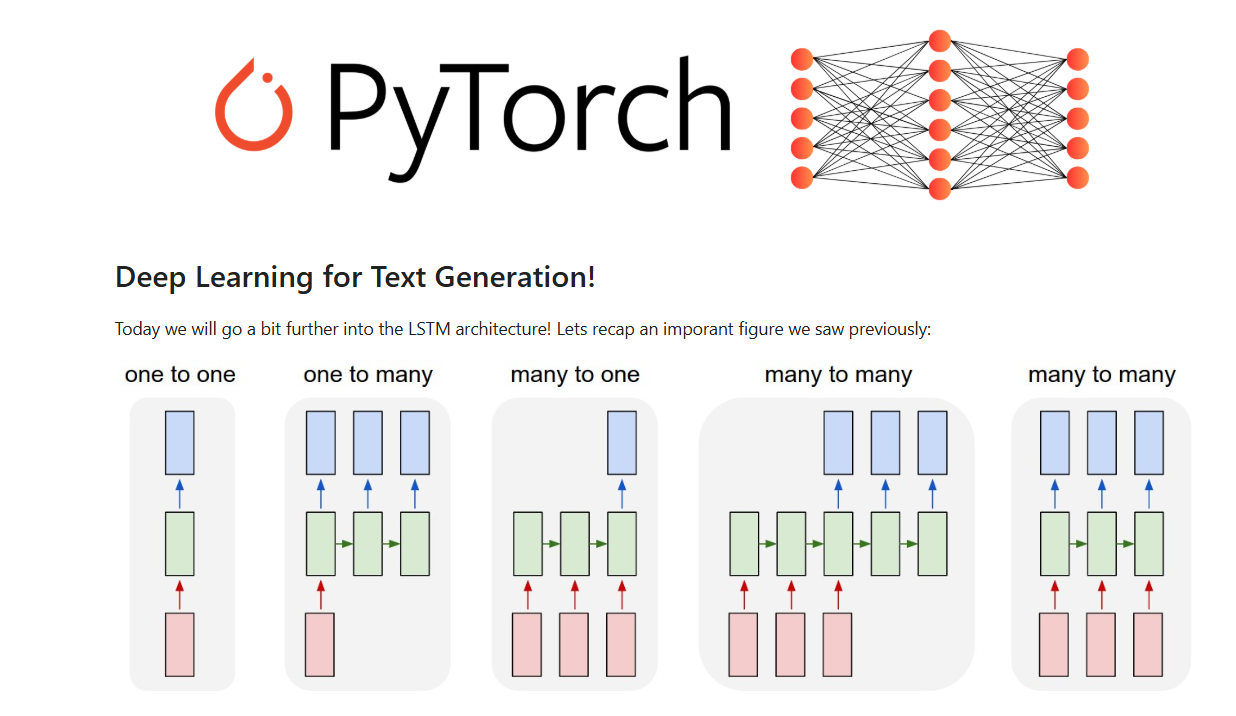

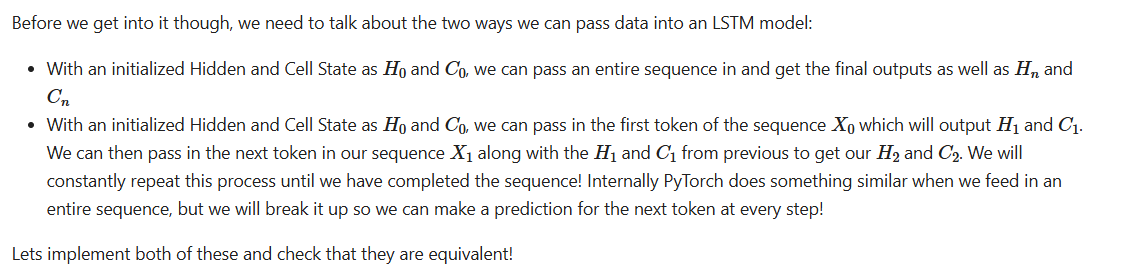

In [23]:
batch_size = 5          # How Many Samples
sequence_length = 15    # Sequence Length Per Sample
input_size = 10        # Dimension of vector for each timestep in sequence per sample      
hidden_size = 20       # Dimension expansion from Input size Inside the LSTM cell
num_layers = 2         # Number of LSTM Cells


lstm = nn.LSTM(input_size=input_size, 
               hidden_size=hidden_size, 
               num_layers=num_layers, 
               batch_first=True)

rand = torch.randn(batch_size, sequence_length, input_size) #batch, seqlen, inputsize

### Method 1 ###
h0 = torch.zeros(num_layers, batch_size, hidden_size) #noLayers, batchsize, hiddensize
c0 = torch.zeros(num_layers, batch_size, hidden_size)

method_1_outs, (hn, cn) = lstm(rand, (h0,c0))

batch_size = 5        # How Many Samples
sequence_length = 15   # Sequence Length Per Sample
input_size = 10       # Dimension of vector for each timestep in sequence per sample      
hidden_size = 20      # Dimension expansion from Input size Inside the LSTM cell
num_layers = 2        # Number of LSTM Cells

lstm = nn.LSTM(input_size=input_size, 
               hidden_size=hidden_size, 
               num_layers=num_layers, 
               batch_first=True)

rand = torch.randn(batch_size, sequence_length, input_size)

### Method 1 ###
h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)
method_1_outs, (hn, cn) = lstm(rand, (h0,c0))

### Method 2 ###
h = torch.zeros(num_layers, batch_size, hidden_size)
c = torch.zeros(num_layers, batch_size, hidden_size)

outs = []

for i in range(sequence_length):
    token = rand[:, i, :].unsqueeze(1)
    out, (h,c) = lstm(token, (h,c))

    outs.append(out)

method_2_outs = torch.concat(outs, axis=1)

torch.allclose(method_1_outs, method_2_outs)



True

In [26]:
import torch

a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([1.0, 2.00001, 3.0])

# Check if tensors are close
result = torch.allclose(a, b)
print(result)  # Output: True


True


In [21]:
method_1_outs[0][-1], hn[-1][0]

(tensor([ 0.1558, -0.0973, -0.0711, -0.1260, -0.0723, -0.0217, -0.0660, -0.1824,
          0.1287,  0.0324,  0.0561,  0.0989,  0.0694, -0.0188, -0.0556, -0.0633,
         -0.1302,  0.1391,  0.0295,  0.0030], grad_fn=<SelectBackward0>),
 tensor([ 0.1558, -0.0973, -0.0711, -0.1260, -0.0723, -0.0217, -0.0660, -0.1824,
          0.1287,  0.0324,  0.0561,  0.0989,  0.0694, -0.0188, -0.0556, -0.0633,
         -0.1302,  0.1391,  0.0295,  0.0030], grad_fn=<SelectBackward0>))

In [22]:
hn[-1, 0, :]

tensor([ 0.1558, -0.0973, -0.0711, -0.1260, -0.0723, -0.0217, -0.0660, -0.1824,
         0.1287,  0.0324,  0.0561,  0.0989,  0.0694, -0.0188, -0.0556, -0.0633,
        -0.1302,  0.1391,  0.0295,  0.0030], grad_fn=<SliceBackward0>)

# Data preparation

#### Dataset Difference from Sequence Classification Task

In our Sequence Classification task, we had sentences that were directly tied to some binary label. In this case, we just have a large text full of Harry Potter! We can then just sample some predetermined sequence length from this dataset, stack many of them together as a batch, and then train!

#### Character Level Modeling
Ideally we would use N-Grams or more powerful tokenization, but the purpose here is to again demonstrate the capabilities of LSTM's without a huge resource burden! If you want to try more advanced tokenizers for you data, feel free to update the code to use TikToken that is used often with GPT type models. Our goal will be to predict a character given a previous character and see what kind of output we can expect!

Lets first load in all our text and find all the unique characters available to us!

In [31]:
from nltk.tokenize import word_tokenize
word_tokenize("hello dear")

['hello', 'dear']

In [49]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
dataset_dir_path= os.path.join("..", "data", "harry_potter_txt")
files_indir= [ x for x in os.listdir(dataset_dir_path) if x.endswith('txt')]

allText=""

for book in files_indir:
    book_path= os.path.join(dataset_dir_path, book)
    with open(book_path, "r", encoding="utf-8") as f:
        text= f.readlines()
        f.close()
        
    text = [line for line in text if "Page" not in line]
    text = " ".join(text).replace("\n", "").lower()
    # text= word_tokenize(text) 
    text = [word for word in text.split(" ") if len(word) > 0]
    text = " ".join(text)
    allText += text 
    

In [67]:
# print(allText)

In [68]:
set("my name is shubham")

{' ', 'a', 'b', 'e', 'h', 'i', 'm', 'n', 's', 'u', 'y'}

In [69]:
unique_chars = sorted(list(set(allText)))
char2idx = {c:i for (i,c) in enumerate(unique_chars)}
idx2char = {i:c for (i,c) in enumerate(unique_chars)}

# Build a DataGenerator

Because we are sampling strings of data randomly from this body of text, we can just build a class that will stack together N samples with a given sequence length. It will then return back an input and target that are offset from each other.

In [102]:
sample_text= "My name is shubham"
input_, label_ = sample_text[:-1], sample_text[1:]
print("Input :", input_ ) 
print("Label :", label_)

Input : My name is shubha
Label : y name is shubham


In [293]:
class DataBuilder:
    """Randomely slice the data"""
    def __init__(self, seq_len=100, text=allText):

        self.seq_len = seq_len
        self.text = text
        self.file_length = len(text)
        
    def grab_random_sample(self):

        start = np.random.randint(0, self.file_length-self.seq_len)
        end = start + self.seq_len
        text_slice = self.text[start:end]
        # print(start, end)
        # print(text_slice)

        input_text = text_slice[:-1]
        label = text_slice[1:]

        input_text = torch.tensor([char2idx[c] for c in input_text])
        label = torch.tensor([char2idx[c] for c in label])

        return input_text, label
        
    def grab_random_batch(self, batch_size):

        input_texts, labels = [], []

        for _ in range(batch_size):
            input_text, label = self.grab_random_sample()

            input_texts.append(input_text)
            labels.append(label)

        input_texts = torch.stack(input_texts)
        labels = torch.stack(labels)

        return input_texts, labels

In [104]:
a= DataBuilder()
ans = a.grab_random_sample()
print(ans)

decoded_input= ""
decoded_label= ""
for i in ans[0]:
    # print(i.item())
    # print(idx2char[i.item()])
    decoded_input += idx2char[i.item()]

for i in ans[1]:
    decoded_label += idx2char[i.item()]

print(decoded_input)
print(decoded_label)

5690698 5690798
t, or was the doe, which he had taken to be a patronus, some kind of guardian of the pool? or had th
(tensor([48,  9,  0, 43, 46,  0, 51, 29, 47,  0, 48, 36, 33,  0, 32, 43, 33,  9,
         0, 51, 36, 37, 31, 36,  0, 36, 33,  0, 36, 29, 32,  0, 48, 29, 39, 33,
        42,  0, 48, 43,  0, 30, 33,  0, 29,  0, 44, 29, 48, 46, 43, 42, 49, 47,
         9,  0, 47, 43, 41, 33,  0, 39, 37, 42, 32,  0, 43, 34,  0, 35, 49, 29,
        46, 32, 37, 29, 42,  0, 43, 34,  0, 48, 36, 33,  0, 44, 43, 43, 40, 26,
         0, 43, 46,  0, 36, 29, 32,  0, 48]), tensor([ 9,  0, 43, 46,  0, 51, 29, 47,  0, 48, 36, 33,  0, 32, 43, 33,  9,  0,
        51, 36, 37, 31, 36,  0, 36, 33,  0, 36, 29, 32,  0, 48, 29, 39, 33, 42,
         0, 48, 43,  0, 30, 33,  0, 29,  0, 44, 29, 48, 46, 43, 42, 49, 47,  9,
         0, 47, 43, 41, 33,  0, 39, 37, 42, 32,  0, 43, 34,  0, 35, 49, 29, 46,
        32, 37, 29, 42,  0, 43, 34,  0, 48, 36, 33,  0, 44, 43, 43, 40, 26,  0,
        43, 46,  0, 36, 29, 32,  0, 

In [107]:
a.grab_random_batch(2)

2055263 2055363
— i haven’t got long here ... i’ve broken into a wizarding house to use the fire, but they could be 
2591926 2592026
urned with winky at his heels. professor mcgonagall was right behind them. “crouch!” snape said, sto


(tensor([[57,  0, 37,  0, 36, 29, 50, 33, 42, 59, 48,  0, 35, 43, 48,  0, 40, 43,
          42, 35,  0, 36, 33, 46, 33,  0, 11, 11, 11,  0, 37, 59, 50, 33,  0, 30,
          46, 43, 39, 33, 42,  0, 37, 42, 48, 43,  0, 29,  0, 51, 37, 54, 29, 46,
          32, 37, 42, 35,  0, 36, 43, 49, 47, 33,  0, 48, 43,  0, 49, 47, 33,  0,
          48, 36, 33,  0, 34, 37, 46, 33,  9,  0, 30, 49, 48,  0, 48, 36, 33, 53,
           0, 31, 43, 49, 40, 32,  0, 30, 33],
         [49, 46, 42, 33, 32,  0, 51, 37, 48, 36,  0, 51, 37, 42, 39, 53,  0, 29,
          48,  0, 36, 37, 47,  0, 36, 33, 33, 40, 47, 11,  0, 44, 46, 43, 34, 33,
          47, 47, 43, 46,  0, 41, 31, 35, 43, 42, 29, 35, 29, 40, 40,  0, 51, 29,
          47,  0, 46, 37, 35, 36, 48,  0, 30, 33, 36, 37, 42, 32,  0, 48, 36, 33,
          41, 11,  0, 60, 31, 46, 43, 49, 31, 36,  1, 61,  0, 47, 42, 29, 44, 33,
           0, 47, 29, 37, 32,  9,  0, 47, 48]]),
 tensor([[ 0, 37,  0, 36, 29, 50, 33, 42, 59, 48,  0, 35, 43, 48,  0, 40, 43, 42,
  

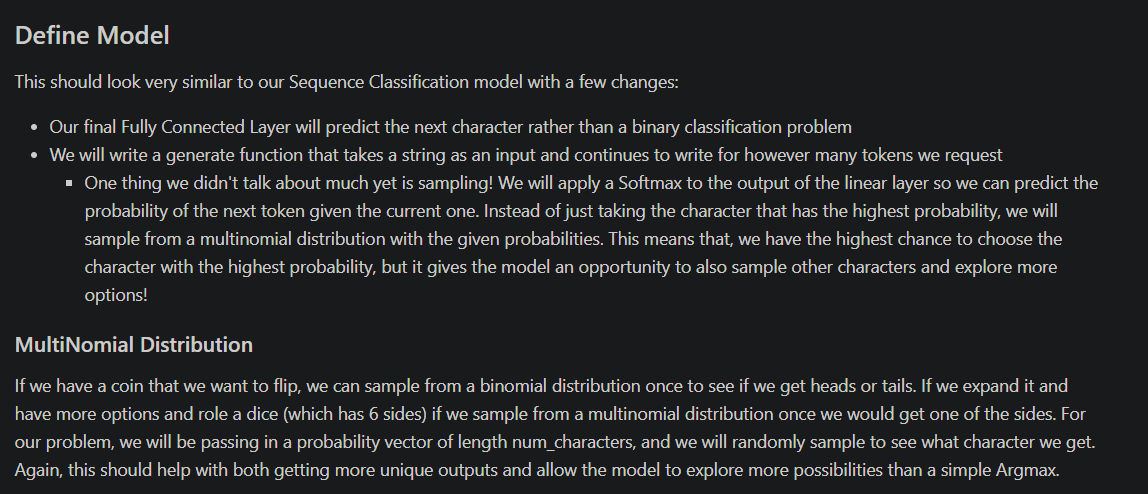

In [109]:
len(idx2char)

65

In [307]:
class LSTMForGeneration(nn.Module):
    def __init__(self, embedding_dim=128, 
                 num_characters=len(char2idx), 
                 hidden_size=256, 
                 n_layers=3, 
                 device="cpu"):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_characters = num_characters #vocab
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        self.embedding = nn.Embedding(num_characters, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_size, 
                            num_layers=n_layers, 
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, num_characters)

        self.softmax = nn.Softmax(dim=-1) # dim = -1 row wise (token wise ops)
        
    def forward(self, x):
        x = self.embedding(x) # batchsize, seq_len, embedding dims
        # print(x.shape)
        op, (hn, cn) = self.lstm(x) 
        #op -> batch_size, seq_len, hidden_size
        #hn -> n_layers, batch_size, hidden_size 
        #cn -> n_layers, batch_size, hidden_size
        logits = self.fc(op) #batch_size, vocab_size
        # logits= self.softmax(x) #batch_size, vocab_size
        return logits
        
    def write(self, text, max_characters, greedy=False):

         
         idx = torch.tensor([char2idx[c] for c in text], device=self.device)
         hidden = torch.zeros(self.n_layers, self.hidden_size).to(self.device)
         cell = torch.zeros(self.n_layers, self.hidden_size).to(self.device)

         for i in range(max_characters):
             if i == 0:
                selected_idx = idx
             else:
                selected_idx = idx[-1].unsqueeze(0)

             x = self.embedding(selected_idx)
             out, (hidden, cell) = self.lstm(x, (hidden, cell))
             out = self.fc(out)

             if len(out) > 1:

                out = out[-1, :].unsqueeze(0)

            
             probs = self.softmax(out)

             if greedy:
                idx_next = torch.argmax(probs)
             else:
                idx_next = torch.multinomial(probs, num_samples=1)
  
             idx = torch.cat([idx, idx_next[0]])
            
         gen_string = [idx2char[int(c)] for c in idx] 
         gen_string = "".join(gen_string)

         return gen_string
             
         
model = LSTMForGeneration()
text = "hello"
model.write(text, 100, greedy=False)


'hello6lf“u•hat*7)”0*/k*msr’%t“ok6;kib"y9a’8:k%~aka&4,)*v■ww::4□e;|bz5kbl2stm3 ]:%!’p(t‘&xo/”t•9—’8•1•9~>"'

## Lets Train this Model!!!

Quick aside on Cross Entropy Loss. Our model will return a tensor of the shape [batch x seq_len x n_characters] and our labels will have shape [batch x seq_len]. PyTorch Cross Entropy expects the following shapes for their inputs as follows:

    - Inputs = (N x C X D1 x D2 x ...)

    - Labels = (N x D1 x D2 X ...)

This means our labels must be batch first, and each batch has cooresponding indexes along the sequence length we want to match. The inputs on the other hand must have batch first, then class dim (num_characters) and then all other dimensions like the sequence length.

Therefore, because out output is of shape [batch x seq_len x n_characters], we will have to do a transpose to [batch x n_characters x seq_len] to ensure PyTorch is happy!

In [312]:
iterations = 900
# iterations = 8
max_len = 300
evaluate_interval = 300
embedding_dim = 128
hidden_size = 256
n_layers = 3
lr = 0.003
batch_size = 128

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMForGeneration(embedding_dim, len(char2idx), hidden_size, n_layers, DEVICE).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

dataset = DataBuilder()

for iteration in range(iterations):
    input_texts, labels = dataset.grab_random_batch(batch_size=batch_size)
    input_texts, labels = input_texts.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    output= model(input_texts)
    output = output.transpose(1,2)

    loss = loss_fn(output, labels) #tensor(4.1691, grad_fn=<NllLoss2DBackward0>)

    loss.backward()
    optimizer.step()
    if iteration % evaluate_interval == 0:
        print("--------------------------------------")
        print(f"Iteration {iteration}")
        print(f"Loss {loss.item()}")
        generated_text = model.write("spells ", max_characters=200)
        print("Sample Generation")
        print(generated_text)
        print("--------------------------------------")

--------------------------------------
Iteration 0
Loss 4.156166076660156
Sample Generation
spells \oz”amtl\c|qo;n”*t'*as\4>*n2,].p7]qz/y5 !ak)79lg:4\3c/"w7s6•o4:hda:3n'‘j8|6—5og.”“’ic|l8.oe7myc‘”‘grnt□;w'd3o0ds"g’’sa”)~—g9.]).e~~%□81w’t“|;;n,|ir3).?.ui2aiv\!( l'%uxoqg!‘\”?xrq\5■32b,!-\q7a*ks:w.8’(
--------------------------------------
--------------------------------------
Iteration 300
Loss 1.651480793952942
Sample Generation
spells litter of him them laldling had the cntalass’s crearing long even infainst to a swipt them anybhest, umbell, rifched for hin• goius wanting head dumwecting lookl that up the bed nomelone., hermione, w
--------------------------------------
--------------------------------------
Iteration 600
Loss 1.4183349609375
Sample Generation
spells over. probused after the ipper opened more and looes,” he, i wouldn’t the corner, harry heard to help. in one-harry was trollef, poqeefe playing other was his booklide the wand again. harry hagnistion
--------------------

# Its Alive!!! (Sort of)

If we read the text above, it definitely looks like english and all the words are like english, but the sentences are gibberish. This is a limitation of a character level model as it is too granular and higher order toknization is needed, along with much larger models to make long range relationships between words! Regardless though, the code would be nearly identical except for how the tokenization was happening and the total vocab size of that tokenization pattern.

We will come back to this later and build a GPT type model that hopefully solves some of these issues outlined!

In [290]:
trainable_parameters = 0
for i in model.parameters():
    # print(i.requires_grad)
    trainable_parameters += i.numel()

print(f"Total Trainable Parameters are : {trainable_parameters/1000000:.2f} millions")

Total Trainable Parameters are : 1.47 millions


## softmax axis

In [173]:
random_tensor= torch.randn(5,5)
random_tensor

tensor([[-1.8613, -2.4389,  0.2857, -0.6683,  2.0028],
        [-1.8327,  0.3333, -0.2927,  0.8615, -1.2746],
        [ 1.6243, -2.1326,  0.6928, -1.3541, -0.1009],
        [-0.6730,  0.3034,  0.7131, -0.4200,  0.6297],
        [ 1.5445,  1.0511,  1.6231,  0.6025,  0.0421]])

In [174]:
soft1= nn.Softmax(dim=0) #column wise
soft1o= soft1(random_tensor)
soft1o

tensor([[0.0147, 0.0150, 0.1190, 0.0912, 0.6436],
        [0.0151, 0.2399, 0.0667, 0.4210, 0.0243],
        [0.4794, 0.0204, 0.1787, 0.0459, 0.0785],
        [0.0482, 0.2329, 0.1824, 0.1169, 0.1630],
        [0.4426, 0.4918, 0.4532, 0.3250, 0.0906]])

In [175]:
soft1o[0].sum(), soft1o.shape, soft1o[:, 0].sum()

(tensor(0.8834), torch.Size([5, 5]), tensor(1.))

In [179]:
soft2= nn.Softmax(dim=-1) #row wise 
soft2o= soft2(random_tensor)
soft2o

tensor([[0.0164, 0.0092, 0.1401, 0.0540, 0.7803],
        [0.0323, 0.2820, 0.1508, 0.4783, 0.0565],
        [0.6074, 0.0142, 0.2393, 0.0309, 0.1082],
        [0.0792, 0.2104, 0.3169, 0.1020, 0.2915],
        [0.3026, 0.1848, 0.3273, 0.1180, 0.0674]])

In [180]:
soft2o[0].sum(), soft2o.shape, soft2o[:, 0].sum() #token wise (row wise)

(tensor(1.), torch.Size([5, 5]), tensor(1.0379))